In [1]:
! wget https://www.dropbox.com/s/gfq7j9fhfihv3fd/dataset_train.json -O dataset_train.json
! wget https://www.dropbox.com/s/lv6xa80h5524spj/dataset_test.json -O dataset_test.json
! wget https://www.dropbox.com/s/wgyetw38nav2rvd/dataset.zip
! unzip dataset.zip

--2019-04-27 19:00:04--  https://www.dropbox.com/s/gfq7j9fhfihv3fd/dataset_train.json
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/gfq7j9fhfihv3fd/dataset_train.json [following]
--2019-04-27 19:00:10--  https://www.dropbox.com/s/raw/gfq7j9fhfihv3fd/dataset_train.json
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc8a11aafc301751fe10acdf4360.dl.dropboxusercontent.com/cd/0/inline/Af21GDmKWAza5iEY3ssXIMGYHlmQdhrpGhQIVVhcQfkGRUeKD_aojXahuG29tB_l5m1oGXhQNHZtfFUKfBrJfHCF3k8U1VTAfw_mmBEx0wTJbjqdXvOtaAfnXTuXKTyu0Y8/file# [following]
--2019-04-27 19:00:10--  https://uc8a11aafc301751fe10acdf4360.dl.dropboxusercontent.com/cd/0/inline/Af21GDmKWAza5iEY3ssXIMGYHlmQdhrpGhQIVVhcQfkGRUeKD_aojXahuG29tB_l5m1oGXhQNHZtfFUKfBrJfHCF3k8U1

In [0]:
import os
import json
import numpy as np
import cv2
from PIL import Image
from matplotlib import pyplot as plt

In [0]:
with open('dataset_train.json') as f:
    dataset_train = json.load(f)

In [0]:
def show(img, figsize=(5, 5)): #画像をinput, 大きさも指定可能にしとく
    plt.figure(figsize=figsize)
    #plt.imgshow(img) # 色の変換が必要。opencv はRGBではなく、BGRで読み込んでしまうため
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [0]:
# https://qiita.com/ka10ryu1/items/bb8f73a732e5da3a1abc
#def cleary(img, clip_limit=3, grid=(8, 8), thresh=225):
#    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=grid)
#    dst = clahe.apply(img)
#    th = dst.copy()
#    th[dst > thresh] = 255
#    return []

In [0]:
def trim_numbers(img, n_digits): #img:画像, n_digit:桁数
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # gray = cleary(gray)
  
    # 文字の輪郭を取得するために二値化する(グレーではなく、白か黒)
    # THRESH_OTSH は自動的に、白黒の閾値を決定する：auto
    _, gray = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    # findContours の機能：輪郭抽出 
    # http://lang.sist.chukyo-u.ac.jp/classes/OpenCV/py_tutorials/py_imgproc/py_contours/py_contours_begin/py_contours_begin.html
    # https://docs.opencv.org/3.0-beta/modules/imgproc/doc/structural_analysis_and_shape_descriptors.html?highlight=cv2.find#cv2.findContours
    #cv2.RETR_EXTERNAL: 一番外側の輪郭のみ抽出する。
    #cv2.RETR_LIST: すべての輪郭を抽出するが、階層構造は作成しない。
    #cv2.RETR_CCOMP: すべての輪郭を抽出し、2階層の階層構造を作成する。
    #cv2.RETR_TREE: すべての輪郭を抽出し、ツリーで階層構造を作成する。
    _, contours, hierarchy = cv2.findContours(gray,
                                              cv2.RETR_LIST, #取得リスト
#                                             cv2.RETR_TREE,
#                                             cv2.RETR_CCOMP,
                                              cv2.CHAIN_APPROX_SIMPLE) #シンプルな線で近似して囲う

  #findContoursにて抽出した画像には、不要なものが含まれている
  #数値の中の丸など面積の小さい領域を除去する
  #cnt に除去後の画像を格納する方針
    cnt = []
    for c in contours: # contourAreaに引数を渡すと面積を返す
        area = cv2.contourArea(c)
        
        # 20ピクセル未満は除外、20ピクセル以上はappend
#        if area < 20:
#            continue
    
        #内接する矩形。横長、縦長の線を除去する 
        x, y, w, h = cv2.boundingRect(c) 
        #幅か高さが100ピクセルのものを除去する
        #cnt に除去後の画像を格納する
        if w > 100 or h > 100:
            continue
        
        cnt.append(c)
    
    #ノイズを除去するために上位○位(n_digits)の高さをもつ値を抽出する
    #抽出の前に高さ順にソート。高さ順にソートすることで、数字の中の不要な○も除去できる
    #幅よりも高さの方が大きな変動はない(1は幅が狭いなど)
    cnt = sorted(cnt, key=lambda x: cv2.boundingRect(x)[-1])
    cnt.reverse() #大きい順にソート
    
    #数値データは上位 n_digits まで抽出する
    numbers = cnt[:n_digits]
    
    # 輪郭の出力
    #show(cv2.drawContours(img.copy(), contours, -1, (0, 255, 0), 1)) #-1:全部出力, (色の指定：緑), 2:太線
    show(cv2.drawContours(img.copy(), numbers, -1, (0, 255, 0), 1)) #-1:全部出力, (色の指定：緑), 2:太線
    
    #n_digit の桁数の抽出に失敗している場合はNoneを返す。そうでない場合はnumbersを返す
    if len(numbers) != n_digits:
        return None
    return numbers

# plt.figure()
# plt.gray() # 白黒は白黒として表示する。これがないと、白が黄色く出力されてしまう
# plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

#  plt.imshow(gray) 
#  return []

In [0]:
def get_rects(numbers):
    #左から順にソートする（x座標でソート）
    numbers = sorted(numbers, key=lambda x:cv2.boundingRect(x)[0])
    result = []
    
    #enumerateを使うと、iは配列の数位、cはnumbersのi番目の要素
    for i, c in enumerate(numbers): 
        x, y, w, h = cv2.boundingRect(c)
        if h > w:
            size = h
            limit = w
        else:
            size = w
            limit = h
        p1 = int((size - limit) / 2)
        p2 = int((size + limit) / 2)
        rect_img = np.full((size, size, 3), 255, np.uint8)
        if h < w:
            rect_img[p1:p2, :] = img[y:y+h, x:x+w]
        else:
            rect_img[:, p1:p2] = img[y:y+h, x:x+w]
            
        rect_img = cv2.resize(rect_img, (28, 28))
        result.append(rect_img)
        show(rect_img, (1, 1))
        
    return result

In [0]:
#画像データをkerasのテンソルに変換(追加)する
# rects: 四角の画像データ、label: 正解ラベル
def append_dataset(X, y, rects, label):
  #forループのzip : 複数のシーケンスオブジェクトに対して同時にループする。要素数が違う場合は一番少ないものに合わせられる
    for r, n in zip(rects, str(label)):
        m = r.reshape((1,) + r.shape) #1つの行列として、まとめる
        X = np.append(X, m, axis=0) #axis=0を省略すると、変な行列になってしまう
        y = np.append(y, [int(n)], axis=0)
    return X, y

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


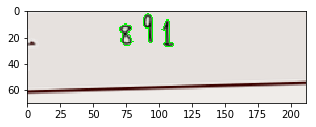

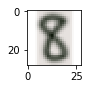

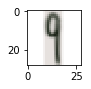

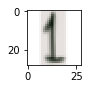

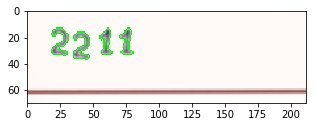

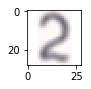

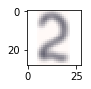

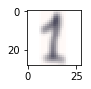

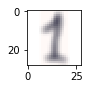

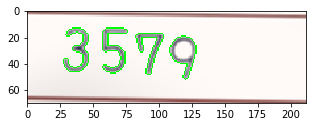

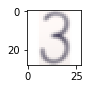

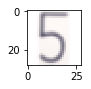

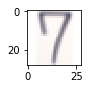

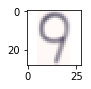

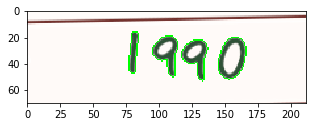

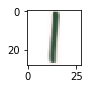

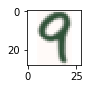

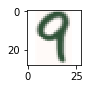

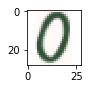

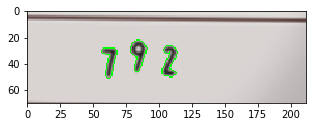

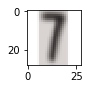

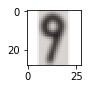

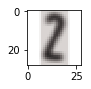

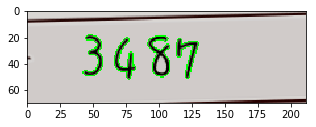

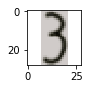

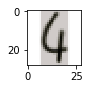

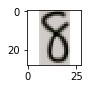

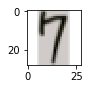

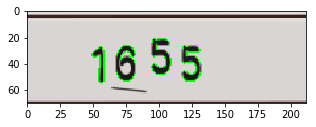

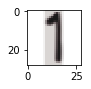

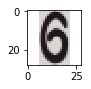

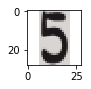

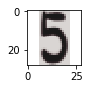

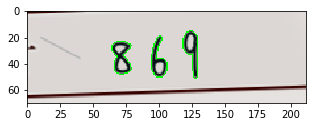

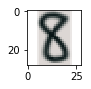

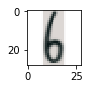

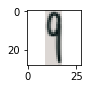

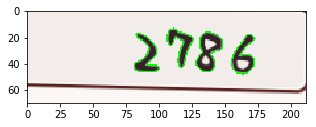

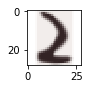

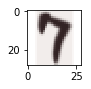

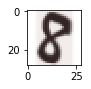

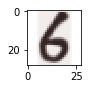

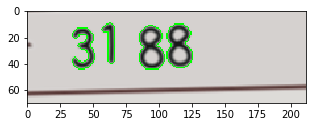

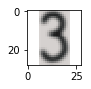

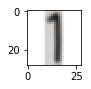

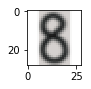

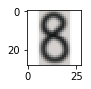

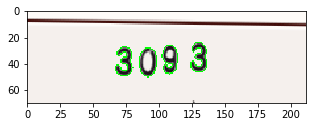

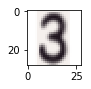

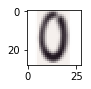

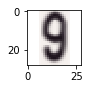

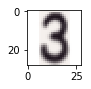

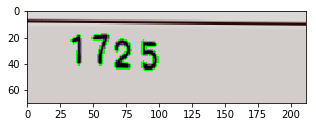

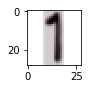

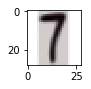

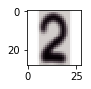

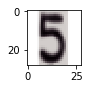

In [78]:
#X, y の空の行列をつくる
#X_train = np.empty((0, 28, 28, 3))
#y_train = np.empty((0))

for i in range(len(dataset_train)):
    filename = dataset_train[i]['file']
    label = dataset_train[i]['total']
    n_digits = len(str(label)) #金額から桁数を算出する
#    print(filename,label, n_digits)
  
    #imread       : 画像の読み込み(image readの略)
    #os.path.join : ディレクトリのパスをOS環境を考慮した上で、最適な文字列で連結してくれる関数
    img = cv2.imread(os.path.join('dataset/train', filename), 1) # 1: フルカラー、0:白黒画像
    # image.shareで画像の.0幅と高さを取得する
    height, width, _ = img.shape

    #トリミングの実施
    img = img[height-105:height-35, 110:width-45]
    height, width, _ = img.shape
  
   # show(img, (10, 10)) # 数値は出力する画像の大きさ
   # show(img) 

    numbers = trim_numbers(img, n_digits)
    if not numbers: #numbersがnullの場合のエラー処理（失敗パターンを飛ばす）
    #失敗パターンを表示するのも大事。もしくは失敗パターン用の処理を実施する
        continue
  
    #矩形領域をとってくる（線のよせあつめではなくて、28 x 28 ピクセルにする）
    #numbersはまだ緑色の寄せ集め
    rects = get_rects(numbers)

#    X_train, y_train = append_dataset(X_train, y_train, rects, label)

#    np.save('X_train.npy', X_train)
#    np.save('y_train.npy', y_train)
    
    if i > 10: #数値以上になったらブレイク
        break #画像がループの数だけでてきてしまって大変なのでつける(1つだけ出力)
  

In [73]:
#from google.colab import files
#files.download('X_train.npy')

FileNotFoundError: ignored